<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Olivia/Olivia__stock_predictor_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# Set plot stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

In [3]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)


# Plotting AAPL close prices to visualize

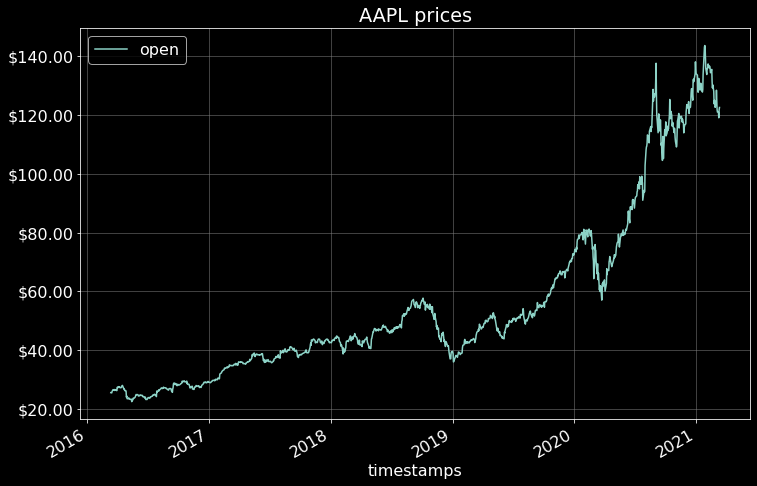

In [4]:
ticker = 'AAPL'
df = getStockData(ticker, "2017", "2020")

ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Method for labeling price data as BUY, HOLD, or SELL

*SELL = 0, BUY = 1, HOLD = 2*


*Parameters:*

    df: Pandas DataFrame
    col_name: Name of the column in df that will be used to determine labels
        - availiable names: "open", "close", "high", "low"
    window_size: How large the window size will be when determining labels
        - default size: 11

In [5]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column

Text(0.5, 1.0, 'Prediction Labels')

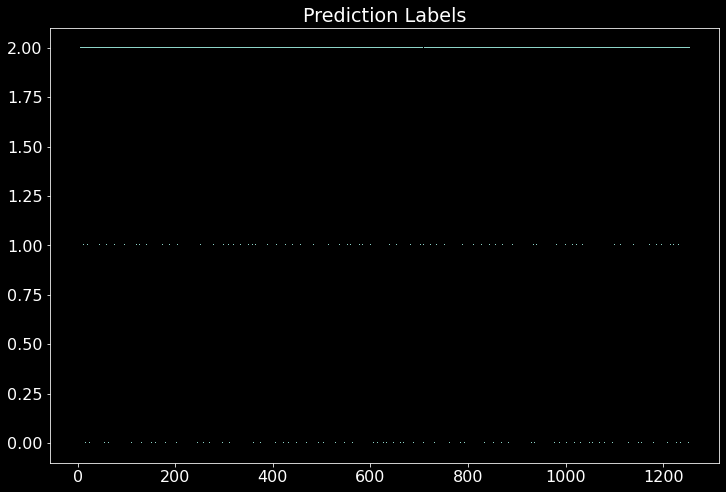

In [6]:
labels = create_labels(df, 'close')
df['labels'] = labels
df['labels'] = df['labels'].fillna(0)

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

# Technical Indicator methods


***Technical Indicators Used:***

*   MACD
*   RSI
*   %K
*   %D
*   ATR
*   DEMA
*   BB
*   WR









In [10]:
# MACD: Moving Average Convergance Diverage Momentum
def calculate_macd(df, iteration):
    # MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
    # The speed of crossovers is also taken as a signal of a market is overbought or oversold.
    # MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.
    df['MACD_'+str(iteration)] = df["close"].ewm(span=iteration).mean() - df["close"].ewm(span=26).mean()
    df['MACD_'+str(iteration)] = df['MACD_'+str(iteration)].fillna(0)
    #df['Signal Line'] = df['MACD'].ewm(span=9).mean()


# RSI: Relative Strength Index 
def calculate_rsi(df, iteration):
    # Signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset's price
    # An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%
    # A momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset
    # The RSI is displayed as an oscillator and can have a reading from 0 to 100.
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    down = abs(down)
    elevenDayUpCloses = up.rolling(iteration).mean() # using 11 day periods
    elevenDayDownCloses = down.rolling(iteration).mean() # using 11 day periods
    relative_strength = elevenDayUpCloses / elevenDayDownCloses
    df['RSI_'+str(iteration)] = 100 - (100/(1+relative_strength))
    df['RSI_'+str(iteration)] = df['RSI_'+str(iteration)].fillna(0)

# SR: Stochastic Oscillator
def calculate_sr(df, iteration):
    # The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low
    # Transaction signals are created when the %K crosses through a three-period moving average, which is called the %D.
    eleven_high = df['high'].rolling(iteration).max()
    eleven_low = df['low'].rolling(iteration).min()
    # %K is referred to sometimes as the fast stochastic indicator
    fast_K = (df['close']-eleven_low)*100/(eleven_high - eleven_low)
    # The "slow" stochastic indicator is taken as %D = 3-period moving average of %K
    df['%D_'+str(iteration)] = fast_K.rolling(3).mean()
    df['%D_'+str(iteration)] = df['%D_'+str(iteration)].fillna(0)

# WR: Williams %R Indicator
def calculate_WR(df, iteration):
    # Williams %R moves between zero and -100.
    # A reading above -20 is overbought.
    # A reading below -80 is oversold.
    eleven_high = df['high'].rolling(iteration).max()
    eleven_low = df['low'].rolling(iteration).min()
    df['WR_'+str(iteration)] = (eleven_high - df['close']) / (eleven_high - eleven_low) * -100
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].rolling(3).mean()
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].fillna(0)
   
# EMA: Exponential Moving Average
def calculate_ema(df, iteration):
    # Moving average that places a greater weight and significance on the most recent data points
    # Traders often use several different EMA lengths, such as 10-day, 50-day, and 200-day moving averages.
    if 'EMA_'+str(iteration) in df.columns:
        return df['EMA_'+str(iteration)]
        print("found EMA column")
    else:
        multiplier = (2/(11+1))
        ema_1 = sum(df['close'],11)
        df['EMA_'+str(iteration)] = (df['close'] -  ema_1) * ema_1 + multiplier # -> Is this right?
        df['EMA_'+str(iteration)] = df['EMA_'+str(iteration)].fillna(0)
        return df['EMA_'+str(iteration)]


# MFI: Money Flow Index
def calculate_mfi(df, iteration):
    price = (df['close'] + df['high'] + df['low']) / 3
    #mf = df['tp'] * df['volume']
    mf = price * df['volume']
    positive_flow = []
    negative_flow = []
    positive_mf = []
    negative_mf = []
    # Loop through typical price calculations
    for i in range(1, len(price)):
        if price[i] > price[i-1]:
            positive_flow.append(mf[i-1])
            negative_flow.append(0)
        elif price[i] < [i-1]:
            negative_flow.append(mf[i-1])
            positive_flow.append(0)
        else:
            positive_flow.append(0)
            negative_flow.append(0) 
    for i in range(len(positive_flow) + 1):
        positive_mf.append(sum(positive_flow[i+1-11:i+1]))
    for i in range(len(negative_flow) + 1):
        negative_mf.append(sum(negative_flow[i+1-11:i+1]))
    df['MFI_'+str(iteration)] = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    df['MFI_'+str(iteration)] = df['MFI_'+str(iteration)].fillna(0)


# BB: Bollinger Band
def calculate_bb(df, iteration):
    # When the bands come close together, constricting the moving average, it is called a squeeze.
    # The mistake most people make is believing that that price hitting or exceeding one of the bands is a signal to buy or sell. 
    # Breakouts provide no clue as to the direction and extent of future price movement.
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['close'] = df['close']
    atr_df['MA11'] = df['close'].rolling(window=iteration).mean()
    atr_df['11STD'] = df['close'].rolling(window=iteration).std()
    atr_df['Upper'] = atr_df['MA11'] + (atr_df['11STD'] * 2) # -> Where is this 2 coming from?
    atr_df['Lower'] = atr_df['MA11'] - (atr_df['11STD'] * 2)
    df['BB_'+str(iteration)] = atr_df[['close','MA11','Upper','Lower']].max(axis=1)
    df['BB_'+str(iteration)] = df['BB_'+str(iteration)].fillna(0)
    # return df['BB']

# ATR: Average True Range
def calculate_atr(df, iteration):

    if 'ATR_'+str(iteration) in df.columns:
        return df['ATR_'+str(iteration)]
    else:
        data = df.copy()
        high = df['high']
        low = df['low']
        close = df['close']
        tr_0 = abs(high - low)
        # Creating temporary Dataframe
        atr_df = pd.DataFrame()
        atr_df['tr0'] = abs(high - low)
        atr_df['tr1'] = abs(high - close.shift())
        atr_df['tr2'] = abs(low - close.shift())
        atr_df['TR'] = atr_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        df['ATR_'+str(iteration)] = atr_df['TR'].ewm(alpha=1/iteration,adjust=False).mean()
        df['ATR_'+str(iteration)] = df['ATR_'+str(iteration)].fillna(0)
        #print(np.where(df['ATR'] < 0))
        return df['ATR_'+str(iteration)]

# KC: Kelter Channel
def calculate_kc(df, iteration):
    #df['KC'] = df.copy
    #KelChM = pd.Series(((df['high'] + df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChM_' + str(11)) 
    #KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChU_' + str(11))  
    #KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChD_' + str(11))
    atr = calculate_atr(df, iteration)
    temp_df = pd.DataFrame()
    temp_df['middle'] = calculate_ema(df, iteration)
    temp_df['upper'] = temp_df['middle'] + 2 * atr
    temp_df['lower'] = temp_df['middle'] - 2 * atr
    df['KC_'+str(iteration)] = temp_df[['middle','upper','lower']].max(axis=1)
    df['KC_'+str(iteration)] = df['KC_'+str(iteration)].fillna(0)
    #print(np.where(temp_df['middle'] > temp_df['upper']))


# DEMA: Double Exponential Moving Average
def calculate_dema(df, iteration):
    multiplier = (2/(iteration+1))
    dema_1 = sum(df['close'],iteration)
    df['DEMA_'+str(iteration)] = (df['close'] * multiplier) + (dema_1 * (1-multiplier))
    df['DEMA_'+str(iteration)] = df['DEMA_'+str(iteration)].fillna(0)


# CCI: Commodity Channel Index
def calculate_cci(df, iteration):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    df['CCI_'+str(iteration)] = ((typical_price - typical_price.rolling(iteration).mean())/ (0.015 * typical_price.rolling(11).std()))
    df['CCI_'+str(iteration)] = df['CCI_'+str(iteration)].fillna(0)


# EMV: Ease of Movement Volume
def calculate_emv(df, iteration):
    distance_moved = ((df['high'] + df['low'])/2) - ((df['high'].shift(1) + df['low'].shift(1))/2)
    box_ratio = (df['volume'] / 100000000) / ((df['high'] - df['low']))
    df['EVM_'+str(iteration)] = distance_moved / box_ratio 
    df['EVM_'+str(iteration)] = df['EVM_'+str(iteration)].fillna(0)


# FI: Force Index
def calculate_fi(df, iteration):
    df['FI_'+str(iteration)] = df['close'].diff(iteration) * df['volume']
    df['FI_'+str(iteration)] = df['FI_'+str(iteration)].fillna(0)


# ROC: Price Rate of Change
def calculate_roc(df, iteration):
    N = df['close'].diff(iteration)
    D = df['close'].shift(iteration)
    df['ROC_'+str(iteration)] = N / D
    df['ROC_'+str(iteration)] = df['ROC_'+str(iteration)].fillna(0)


# OBV: On-Balance Volume
def calculate_obv(df, iteration):
    df['OBV_'+str(iteration)] = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'],0)).cumsum()
    df['OBV_'+str(iteration)] = df['OBV_'+str(iteration)].fillna(0)

In [8]:
#calculate_kc(df)

# Run all Technical Indicator methods

In [11]:
indicator_range = 20
x = 6

# for x in range(1, indicator_range+1):
#     calculate_macd(df, x)
#     calculate_rsi(df, x)
#     calculate_sr(df, x)
#     calculate_WR(df, x)
#     calculate_ema(df, x)
#     calculate_mfi(df, x)
#     calculate_bb(df, x)
#     calculate_atr(df, x)
#     calculate_kc(df, x)
#     calculate_dema(df, x)
#     calculate_cci(df, x)
#     calculate_emv(df, x)
#     calculate_fi(df, x)
#     calculate_roc(df, x)
#     calculate_obv(df, x)

for x in range(1, indicator_range+1):
    calculate_macd(df, x)
for x in range(1, indicator_range+1):
    calculate_rsi(df, x)
for x in range(1, indicator_range+1):
    calculate_sr(df, x)
for x in range(1, indicator_range+1):
    calculate_WR(df, x)
for x in range(1, indicator_range+1):
    calculate_ema(df, x)
for x in range(1, indicator_range+1):
    calculate_mfi(df, x)
for x in range(1, indicator_range+1):
    calculate_bb(df, x)
for x in range(1, indicator_range+1):
    calculate_atr(df, x)
for x in range(1, indicator_range+1):
    calculate_kc(df, x)
for x in range(1, indicator_range+1):
    calculate_dema(df, x)
for x in range(1, indicator_range+1):
    calculate_cci(df, x)
for x in range(1, indicator_range+1):
    calculate_emv(df, x)
for x in range(1, indicator_range+1):
    calculate_fi(df, x)
for x in range(1, indicator_range+1):
    calculate_roc(df, x)
for x in range(1, indicator_range+1):
    calculate_obv(df, x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


# Plot charts for Technical Indicators

<Figure size 864x576 with 0 Axes>

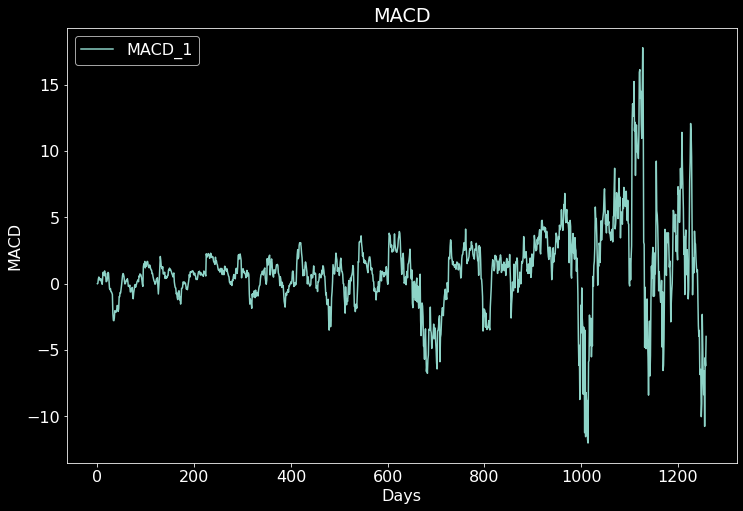

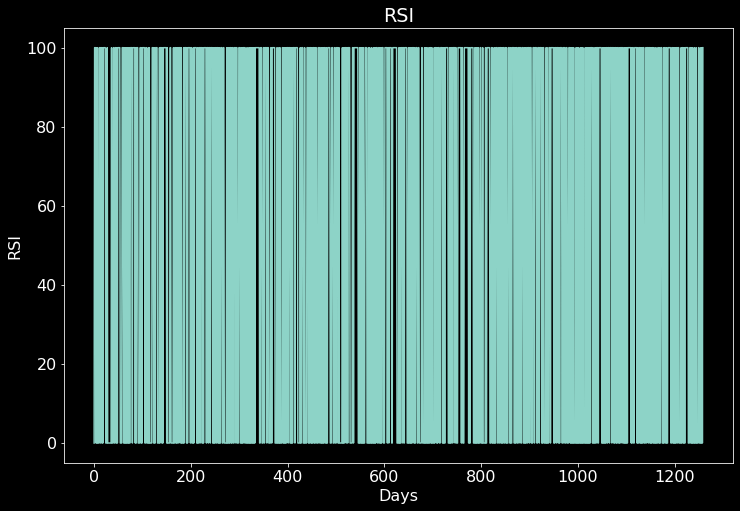

In [12]:
def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)

plot_indicators(df, ['MACD_1'], "MACD", "Days")
plot_indicators(df, "RSI_1", "RSI", "Days")

# Normalization of the Data

In [24]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

pd.options.display.max_columns = 20

print(df.columns)
list_features = list(df.loc[:, 'open': 'OBV_'+str(indicator_range)].columns) # Gets the names of all the columns from MACD to RSI
print('Total number of features', len(list_features))
print("Columns:", list_features)


# df.loc[:, 'MACD':'RSI'].values: -> Data used to create 'x_train' and 'x_test'
# df['labels'].values: -> Data used to create 'y_train' and 'y_test'
#print(df.loc[:, 'MACD':'OBV'])
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open': 'OBV_'+str(indicator_range)].values, df['labels'].values, train_size=0.8, test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

if 0.7*x_train.shape[0] < 2500:
    # If training dataset is small, it increases the percentage of training
    train_split = 0.8
else:
    train_split = 0.7

print('train_split =', train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)

mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
#print(x_train[0])
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Index(['timestamps', 'open', 'high', 'low', 'close', 'volume', 'labels',
       'MACD_1', 'MACD_2', 'MACD_3',
       ...
       'OBV_11', 'OBV_12', 'OBV_13', 'OBV_14', 'OBV_15', 'OBV_16', 'OBV_17',
       'OBV_18', 'OBV_19', 'OBV_20'],
      dtype='object', length=307)
Total number of features 306
Columns: ['open', 'high', 'low', 'close', 'volume', 'labels', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'W

# Feature Selection

*3rd deviation from original paper*

In [25]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

num_features = 225  # should be a perfect square
selection_method = 'anova'
topk = 320 if selection_method == 'all' else num_features

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)  # x_train[:, feat_idx] will give you training data with desired features

('close', 'volume', 'labels', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'EMA_14', 'EMA_15', 'EMA_16', 'EMA_17', 'EMA_18', 'EMA_19', 'EMA_20', 'MFI_1', 'MFI_2', 'MFI_3', 'MFI_4', 'MFI_5', 'MFI_6', 'MFI_7', 'MFI_8', 'MFI_9', 'MFI_10', 'MFI_11', 'MFI_12', 'MFI_13', 'MFI_14', 'MFI_15', 'MFI_16', 'MFI_

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


# Method: *reshape_as_image*

In [26]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

# Reshaping the Data as an Image

In [27]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (805, 15, 15, 3) (805,) (252, 15, 15, 3) (252,)


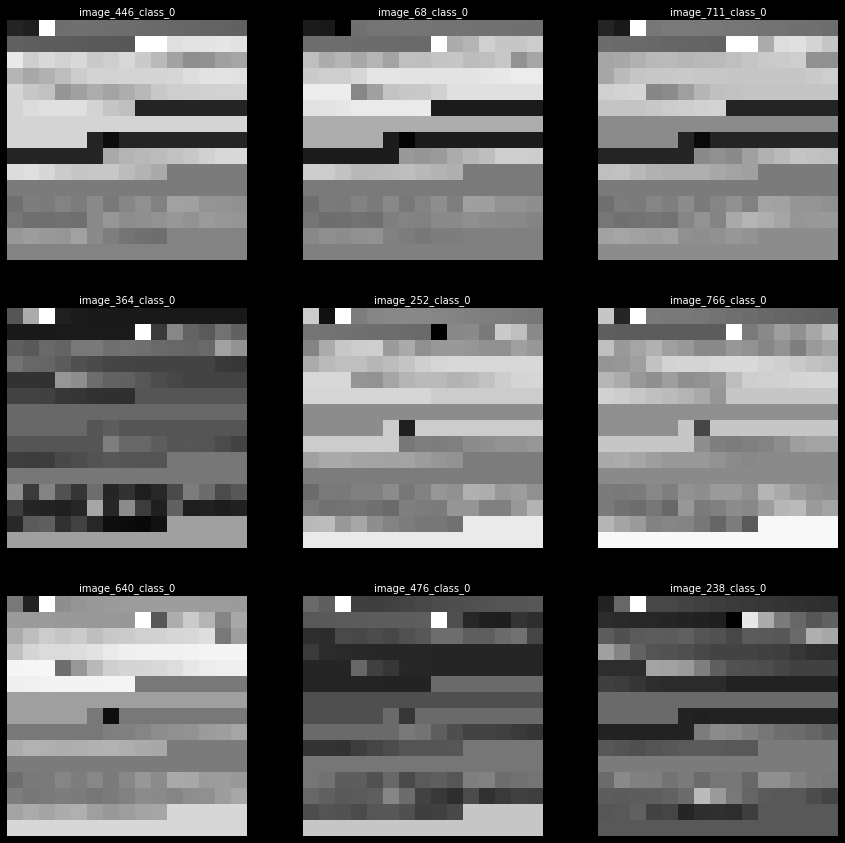

In [28]:
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

# Building Convolutional Neural Network

In [17]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

model = Sequential([
    Conv2D(filters=32, 
           kernel_size=3, 
           strides=1, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True,
           kernel_initializer='glorot_uniform',
           input_shape=(x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2])),
    Dropout(rate=0.2),
    Conv2D(filters=64, 
           kernel_size=3, 
           strides=2, 
           kernel_regularizer=regularizers.l2(0.0), 
           padding='same', 
           activation='relu', 
           use_bias=True, 
           kernel_initializer='glorot_uniform'),
    MaxPool2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(units=128, 
          activation='relu'),
    Dropout(rate=0.3),
    Dense(units=3, activation='softmax')
])

In [18]:
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compiling Model



*   *Optimizer:* Adam
*   *Loss:* Categorical Crossentropy



In [19]:
from tensorflow.keras import optimizers

optimizer_model = 'adam'
learning_rate = 0.001

if optimizer_model == 'rmsprop':
    optimizer = optimizers.RMSprop(lr=learning_rate)
elif optimizer_model == 'sgd':
    optimizer = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
elif optimizer_model == 'adam':
    optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])